# Direct Coupling with $\alpha$ dispersion

This notebook computes the Hamiltonian of the tunable gap flux qubit capacitively coupled to a quantum harmonic oscillator circuit shown in figure 16 of Billangeon.

<center><img src="images/circuit - resonator coupling - alpha dispersion.png" width=600 height=600/></center>
<center>Figure 16: Qubit + Resonator Circuit</center>

$\newline$

Represented by the Hamiltonian:

\begin{equation}
    H = \omega_r' a^\dagger a + \frac{\Delta}{2} \sigma_z + i g_{\parallel} \sigma_z \left( a^\dagger - a \right) + g_{\perp} \sigma_z \left( a^\dagger + a \right)
\end{equation}

## Install and Import Required Packages

In [1]:
%%capture out
!pip install matplotlib
!pip install scipy
!pip install matplotlib
!pip install tdqm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg
import scipy.sparse as sparse
import json

from tqdm import tqdm

plt.style.use('science')

## Initialise Constants

In [2]:
h = 6.626e-34
hbar = 1.055e-34
e_charge = 1.60218e-19
flux_quanta = h / (2 * e_charge)

## Construct System Class

In [22]:
class SparseSystem:
    
    def __init__(self, Ejp=121e9, Ejt=121e9, Cjp=8e-15, Cjt=60e-15, Cc=5e-15, Ct=100e-15, alphas=[0.4]*2, ng=0.25, flux=0.5, ncut=2):
        self.h = 6.626e-34
        self.hbar = 1.055e-34
        self.e_charge = 1.60218e-19
        
        self.Ejp = Ejp * self.h                 # Josephson energy of probe
        self.Ejt = Ejt * self.h                 # Josephson energy of target
        self.Cjp = Cjp                          # Josephson capacitance of probe
        self.Cjt = Cjt                          # Josephson capacitance of target
        self.Ct = Ct                            # Target Capacitor
        self.Cc = Cc                            # Coupling capacitance
        self.ng = ng                            # Reduced gate charge
        self.flux = flux                        # Flux through qubit
        self.ncut = ncut                        # Cut-off threshold for number basis
        self.alphas = alphas
        
        self.init_operators()
        
    def _print_params(self):
        print(f'EJ:    {self.EJ}')
        print(f'CJ:    {self.CJ}')
        print(f'Cr:    {self.Cr}')
        print(f'Cc:    {self.Cc}')
        print(f'Lr:    {self.Lr}')
        print(f'alphas: {self.alphas}')
        print(f'ng:    {self.ng}')
        print(f'flux:  {self.flux}')

    def init_operators(self):
        self.I_cb = sp.sparse.diags(np.ones(2 * self.ncut + 1))   # Identity for qubit (charge basis)
        
        self.q_op_cb = sp.sparse.diags(2 * self.e_charge * np.arange(-self.ncut, self.ncut + 1, dtype=np.complex_))           # Charge operator (charge basis)
        self.ng_op_cb = 2 * self.e_charge * self.ng * self.I_cb
        self.e_iphi_op_cb = sp.sparse.diags(np.ones(2 * self.ncut, dtype=np.complex_), offsets=1)
        
        self.q1_q1_pt = self.tensor4(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb, self.I_cb)
        self.q1_q2_pt = self.tensor4(self.q_op_cb, self.q_op_cb, self.I_cb, self.I_cb)
        self.q1_q3_pt = self.tensor4(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.I_cb)
        self.q1_q4_pt = self.tensor4(self.q_op_cb, self.I_cb, self.I_cb, self.q_op_cb)
        self.q2_q2_pt = self.tensor4(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb)
        self.q2_q3_pt = self.tensor4(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb, self.I_cb)
        self.q2_q4_pt = self.tensor4(self.I_cb, self.q_op_cb, self.I_cb, self.q_op_cb)
        self.q3_q3_pt = self.tensor4(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb), self.I_cb)
        self.q3_q4_pt = self.tensor4(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.q_op_cb)
        self.q4_q4_pt = self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.q_op_cb @ self.q_op_cb)
        
        self.q1_p = self.tensor3(self.q_op_cb, self.I_cb, self.I_cb)
        self.q2_p = self.tensor3(self.I_cb, self.q_op_cb, self.I_cb)
        self.q3_p = self.tensor3(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        
        self.q1_q1_p = self.tensor3(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb)
        self.q1_q2_p = self.tensor3(self.q_op_cb, self.q_op_cb, self.I_cb)
        self.q1_q3_p = self.tensor3(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        self.q2_q2_p = self.tensor3(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb)
        self.q2_q3_p = self.tensor3(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb)
        self.q3_q3_p = self.tensor3(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb))
    
    def tensor3(self, op1, op2, op3):
        return sparse.kron(sparse.kron(op1, op2), op3)
    
    def tensor4(self, op1, op2, op3, op4):
        return sparse.kron(sparse.kron(sparse.kron(op1, op2), op3), op4)
    
    def hc(self, state):
        return np.conjugate(state).T
        
    def get_kin_pt(self):
        self.init_operators()
        
        C_mat = [
            [(1 + self.alphas[0]) * self.Cjp, 0, -self.alphas[0] * self.Cjp, 0],
            [0, (1 + self.alphas[1]) * self.Cjp, -self.alphas[1] * self.Cjp, 0],
            [-self.alphas[0] * self.Cjp, -self.alphas[1] * self.Cjp, sum(self.alphas) * self.Cjp + self.Cc, -self.Cc],
            [0, 0, -self.Cc, self.Cjt + self.Cc + self.Ct]
        ]
        
        C_mat_in = np.linalg.inv(C_mat)

        kin_pt = C_mat_in[0][0] * self.q1_q1_pt
        kin_pt += C_mat_in[1][1] * self.q2_q2_pt
        kin_pt += C_mat_in[2][2] * self.q3_q3_pt
        kin_pt += C_mat_in[3][3] * self.q4_q4_pt
        kin_pt += 2 * C_mat_in[0][1] * self.q1_q2_pt
        kin_pt += 2 * C_mat_in[0][2] * self.q1_q3_pt
        kin_pt += 2 * C_mat_in[0][3] * self.q1_q4_pt
        kin_pt += 2 * C_mat_in[1][2] * self.q2_q3_pt
        kin_pt += 2 * C_mat_in[1][3] * self.q2_q4_pt
        kin_pt += 2 * C_mat_in[2][3] * self.q3_q4_pt
        
        kin_pt *= 0.5

        return kin_pt

    def get_pot_pt(self):
        self.init_operators()
        
        pot_pt = -self.Ejp * 0.5 * self.tensor4(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.tensor4(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.alphas[0] * self.tensor4(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.alphas[0] * self.tensor4(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.alphas[1] * np.exp(2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T, self.I_cb)
        pot_pt += -self.Ejp * 0.5 * self.alphas[1] * np.exp(-2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb, self.I_cb)
        pot_pt += self.Ejp * (sum(self.alphas) + 2) * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.I_cb)
        
        pot_pt += self.Ejt * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.I_cb)        
        pot_pt += -self.Ejt * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T)
        
        return pot_pt
        
    def get_kin_p(self):
        self.init_operators()
        
        C_mat = [
            [(1 + self.alphas[0]) * self.Cjp, 0, -self.alphas[0] * self.Cjp],
            [0, (1 + self.alphas[1]) * self.Cjp, -self.alphas[1] * self.Cjp],
            [-self.alphas[0] * self.Cjp, -self.alphas[1] * self.Cjp, sum(self.alphas) * self.Cjp + self.Cc]
        ]
        
        C_mat_in = np.linalg.inv(C_mat)

        kin_p = C_mat_in[0][0] * self.q1_q1_p
        kin_p += C_mat_in[1][1] * self.q2_q2_p
        kin_p += C_mat_in[2][2] * self.q3_q3_p
        kin_p += 2 * C_mat_in[0][1] * self.q1_q2_p
        kin_p += 2 * C_mat_in[0][2] * self.q1_q3_p
        kin_p += 2 * C_mat_in[1][2] * self.q2_q3_p
        
        kin_p *= 0.5
        
        return kin_p

    def get_pot_p(self):
        self.init_operators()

        pot_p = -self.Ejp * 0.5 * self.tensor3(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb)
        pot_p += -self.Ejp * 0.5 * self.alphas[0] * self.tensor3(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb)
        pot_p += -self.Ejp * 0.5 * self.alphas[0] * self.tensor3(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T)
        pot_p += -self.Ejp * 0.5 * self.alphas[1] * np.exp(2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T)
        pot_p += -self.Ejp * 0.5 * self.alphas[1] * np.exp(-2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb)
        pot_p += -self.Ejp * 0.5 * self.tensor3(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb)
        pot_p += self.Ejp * (2 + sum(self.alphas)) * self.tensor3(self.I_cb, self.I_cb, self.I_cb)
        
        return pot_p
        
    def get_kin_t(self):
        self.init_operators()
        
        kin_t = 0.5 * (self.q_op_cb @ self.q_op_cb) / (self.Cjt + self.Ct + self.Cc)

        return kin_t

    def get_pot_t(self):
        self.init_operators()
        
        pot_t = self.Ejt * self.I_cb
        pot_t += -self.Ejt * (self.e_iphi_op_cb + self.e_iphi_op_cb.T)
        
        return pot_t

    def get_H_pt(self):
        self.H_pt = self.get_kin_pt() + self.get_pot_pt()
        self.H_pt.eliminate_zeros()
        
        return self.H_pt

    def get_H_p(self):
        self.H_p = self.get_kin_p() + self.get_pot_p()
        self.H_p.eliminate_zeros()
        
        return self.H_p

    def get_H_t(self):
        self.H_t = self.get_kin_t() + self.get_pot_t()
        
        return self.H_t
    
    def diagonalise_pt(self, update=False):
        if update:
            self.get_H_pt()
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()
        
        self.evals_pt, evecs = sparse.linalg.eigs(
            self.H_pt, k=10, which='SR'
        )
        
        evecs = evecs.T
        self.evecs_pt = [
            sp.sparse.csr_array(evecs[0]),
            sp.sparse.csr_array(evecs[1]),
        ]
        
        return self.evals_pt, self.evecs_pt
    
    def diagonalise_p(self, update=False):
        if update:
            self.get_H_p()
        else:
            try:
                self.H_p
            except AttributeError:
                self.get_H_p()
        
        self.evals_p, evecs = sparse.linalg.eigs(
            self.H_p, k=10, which='SR'
        )
        
        evecs = evecs.T
        self.evecs_p = [
            sp.sparse.csr_array(evecs[0]),
            sp.sparse.csr_array(evecs[1]),
        ]
        
        return self.evals_p, self.evecs_p
    
    def diagonalise_t(self, update=False):
        if update:
            self.get_H_t()
        else:
            try:
                self.H_t
            except AttributeError:
                self.get_H_t()
        
        self.evals_t, evecs = sparse.linalg.eigs(
            self.H_t, k=2, which='SR'
        )
        
        evecs = evecs.T
        self.evecs_t = [
            sp.sparse.csr_array(evecs[0]),
            sp.sparse.csr_array(evecs[1]),
        ]
        
        return self.evals_t, self.evecs_t
    
    def init_probe_states(self, update=False):
        if update:
            self.diagonalise_p(update=True)
            self.diagonalise_t(update=True)
        else:
            try:
                self.evecs_p
                self.evecs_t
            except AttributeError:
                self.diagonalise_p()
                self.diagonalise_t()

        self.probe_0_eb = self.evecs_p[0].T
        self.probe_1_eb = self.evecs_p[1].T
        self.probe_m_eb = 2**-0.5 * (self.probe_0_eb - self.probe_1_eb)
        self.probe_p_eb = 2**-0.5 * (self.probe_0_eb + self.probe_1_eb)

        self.target_0_eb = self.evecs_t[0].T
        self.target_1_eb = self.evecs_t[1].T
        self.target_m_eb = 2**-0.5 * (self.target_0_eb - self.target_1_eb)
        self.target_p_eb = 2**-0.5 * (self.target_0_eb + self.target_1_eb)
        
        self.target_0_cb = sp.sparse.csr_matrix((2 * self.ncut + 1,1))
        self.target_0_cb[self.ncut,0] = 1
        self.target_1_cb = sp.sparse.csr_matrix((2 * self.ncut + 1,1))
        self.target_1_cb[self.ncut + 1,0] = 1

    def init_prod_states(self, update=False):
        if update:
            self.init_probe_states(update=True)
        else:
            try:
                self.probe_0
            except AttributeError:
                self.init_probe_states()

        self.eb_eb_00 = sp.sparse.kron(self.probe_0_eb, self.target_0_eb)
        self.eb_eb_01 = sp.sparse.kron(self.probe_0_eb, self.target_1_eb)
        self.eb_eb_10 = sp.sparse.kron(self.probe_1_eb, self.target_0_eb)
        self.eb_eb_11 = sp.sparse.kron(self.probe_1_eb, self.target_1_eb)

        self.eb_cb_00 = sp.sparse.kron(self.probe_0_eb, self.target_0_cb)
        self.eb_cb_01 = sp.sparse.kron(self.probe_0_eb, self.target_1_cb)
        self.eb_cb_10 = sp.sparse.kron(self.probe_1_eb, self.target_0_cb)
        self.eb_cb_11 = sp.sparse.kron(self.probe_1_eb, self.target_1_cb)
        self.eb_cb_p0 = sp.sparse.kron(self.probe_p_eb, self.target_0_cb)
        self.eb_cb_p1 = sp.sparse.kron(self.probe_p_eb, self.target_1_cb)
        self.eb_cb_m0 = sp.sparse.kron(self.probe_m_eb, self.target_0_cb)
        self.eb_cb_m1 = sp.sparse.kron(self.probe_m_eb, self.target_1_cb)
    
    def calc_delta_p(self, update=False):
        if update:
            self.get_H_pt()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()

        delta_p = (self.hc(self.eb_eb_10).dot(self.H_pt.dot(self.eb_eb_10)) - self.hc(self.eb_eb_00).dot(self.H_pt.dot(self.eb_eb_00))).toarray()[0][0]
        
        return delta_p
    
    def calc_delta_t(self, update=False):
        if update:
            self.get_H_pt()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()

        delta_t = (self.hc(self.eb_eb_01).dot(self.H_pt.dot(self.eb_eb_01)) - self.hc(self.eb_eb_00).dot(self.H_pt.dot(self.eb_eb_00))).toarray()[0][0]

        return delta_t
    
    def calc_g_parr(self, update=False):
        if update:
            self.get_H_pt()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()

            try:
                self.eb_cb_p1
            except AttributeError:
                self.init_prod_states()
        
        g_parr = self.hc(self.eb_cb_p1).dot(self.H_pt.dot(self.eb_cb_m1)).toarray()[0][0] - self.hc(self.eb_cb_p0).dot(self.H_pt.dot(self.eb_cb_m0)).toarray()[0][0]
        
        return g_parr
    
    def calc_g_perp(self, update=False):
        if update:
            self.get_H_pt()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_pt
            except AttributeError:
                self.get_H_pt()

            try:
                self.eb_cb_11
            except AttributeError:
                self.init_prod_states()
        
        g_perp = self.hc(self.eb_cb_11).dot(self.H_pt.dot(self.eb_cb_01)).toarray()[0][0] - self.hc(self.eb_cb_10).dot(self.H_pt.dot(self.eb_cb_00)).toarray()[0][0]
        
        return g_perp

## $\alpha$ Dispersions

### ($\alpha_1$=0.5) vs $\alpha_2$, ($\alpha_3$ = $\alpha_4$ = 1)

#### Figure 17a

In [26]:
fig_17a_ngs_p = np.linspace(-1, 1, 100)
alpha2s = np.linspace(0.3, 0.7, 5)

system = SparseSystem(ncut=5, Cc=0)

fig_17a_results_p = {}

for alpha2 in alpha2s:
    fig_17a_results_p[alpha2] = []
    system.alphas = [0.5, alpha2]
    for ng in tqdm(fig_17a_ngs_p):
        system.ng = ng

        # Full Hamiltonina Approach
        delta_p = system.calc_delta_p(update=True)
        
        fig_17a_results_p[alpha2].append(delta_p)

  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 100/100 [00:33<00:00,  3.02it/s]


/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards

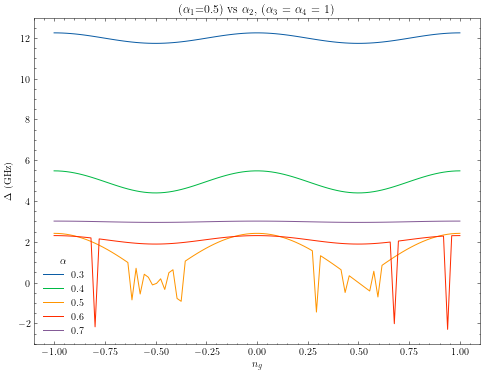

In [27]:
plt.figure(figsize=(8,6))
plt.title('($\\alpha_1$=0.5) vs $\\alpha_2$, ($\\alpha_3$ = $\\alpha_4$ = 1)')
plt.xlabel('$n_g$')
plt.ylabel('$\\Delta$ (GHz)')

for alpha in fig_17a_results_p.keys():
    plt.plot(fig_17a_ngs_p, [val * 1e-9 / h for val in fig_17a_results_p[alpha]], label=round(alpha,2))
plt.legend(title='$\\alpha$')
plt.show()

#### Figure 17c

In [28]:
fig_17c_ngs_alphas12 = np.linspace(-1, 1, 100)
alpha2s = [0.49, 0.499, 0.4999, 0.5, 0.5001, 0.501, 0.51]

system = SparseSystem(ncut=5, Cc=8e-15)

fig_17c_results_alphas12 = {}
g_parr_alpha12_disp, g_perp_alpha12_disp = {}, {}

for alpha2 in alpha2s:
    g_parr_alpha12_disp[alpha2], g_perp_alpha12_disp[alpha2] = [], []
    system.alphas = [0.5, alpha2, 1, 1]
    for ng in tqdm(fig_17c_ngs_alphas12):
        system.ng = ng

        g_parr = system.calc_g_parr(update=True) * 1e-6 / h
        g_parr_alpha12_disp[alpha2].append(g_parr)

        g_perp = system.calc_g_perp() * 1e-6 / h
        g_perp_alpha12_disp[alpha2].append(g_perp)

  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|█████████████████████████████████████████| 100/100 [00:35<00:00,  2.80it/s]


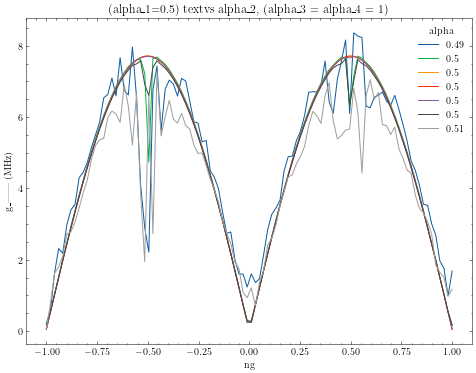

In [30]:
plt.figure(figsize=(8,6))
plt.title(r'(alpha_1=0.5) text{vs} alpha_2, (alpha_3 = alpha_4 = 1)')
plt.xlabel('ng')
plt.ylabel('g_|| (MHz)')

for alpha in g_parr_alpha12_disp.keys():
    plt.plot(fig_17c_ngs_alphas12, np.abs(g_parr_alpha12_disp[alpha]), label=round(alpha,2))
plt.legend(title='alpha')
plt.show()

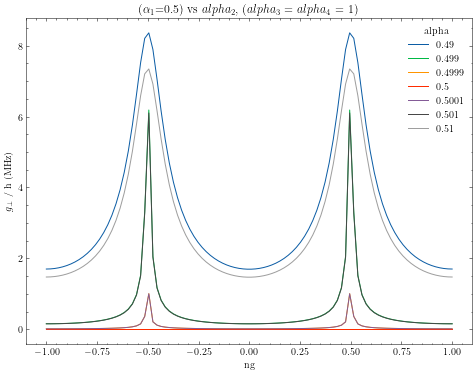

In [34]:
plt.figure(figsize=(8,6))
plt.title(r'($\alpha_1$=0.5) vs $alpha_2$, ($alpha_3$ = $alpha_4$ = 1)')
plt.xlabel('ng')
plt.ylabel('$g_\perp$ / h (MHz)')

for alpha in g_perp_alpha12_disp.keys():
    plt.plot(fig_17c_ngs_alphas12, np.abs(g_perp_alpha12_disp[alpha]), label=round(alpha,5))
plt.legend(title='alpha')
plt.show()

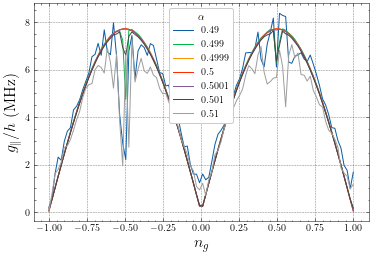

In [36]:
pparam = dict(xlabel='$n_g$', ylabel='$g_\parallel / h$ (MHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for alpha in g_parr_alpha12_disp.keys():
        ax.plot(fig_17c_ngs_alphas12, np.abs(g_parr_alpha12_disp[alpha]), label=alpha)
    ax.legend(title='$\\alpha$')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_parr wrt alpha dispersion ng.png', dpi=300)
    plt.show()

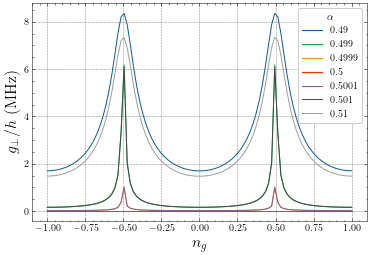

In [37]:
pparam = dict(xlabel='$n_g$', ylabel='$g_\perp / h$ (MHz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for alpha in g_perp_alpha12_disp.keys():
        ax.plot(fig_17c_ngs_alphas12, np.abs(g_perp_alpha12_disp[alpha]), label=alpha)
    ax.legend(title='$\\alpha$')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('figures/Direct Coupling/g_perp wrt alpha dispersion ng.png', dpi=300)
    plt.show()

### Direct Qubit Simulation

#### Fig 17a

In [15]:
fig_17a_ngs_p = np.linspace(-1, 1, 100)
alphas = np.linspace(0.25, 0.6, 2)
alphas = np.linspace(0.25, 0.6, 2)

system = SparseSystem(ncut=3, Cc=0)

fig_17a_results_p = {}

for alpha in alphas:
    fig_17a_results_q[alpha] = []
    system.alpha = alpha
    for ng in tqdm(fig_17a_ngs_q):

        system.ng = ng

        evals, evecs = system.diagonalise_q(update=True)
        evals = np.real(evals) * 1e-9 / h

        delta = evals[1] - evals[0]

        fig_17a_results_q[alpha].append(delta)

100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.24it/s]


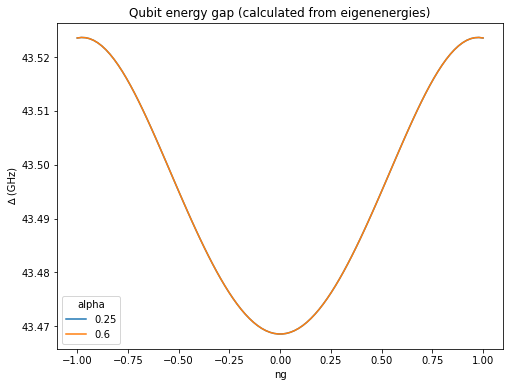

In [16]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('∆ (GHz)')

for alpha in fig_17a_results_q.keys():
    plt.plot(fig_17a_ngs_q, fig_17a_results_q[alpha], label=round(alpha,2))
plt.legend(title='alpha')
plt.show()

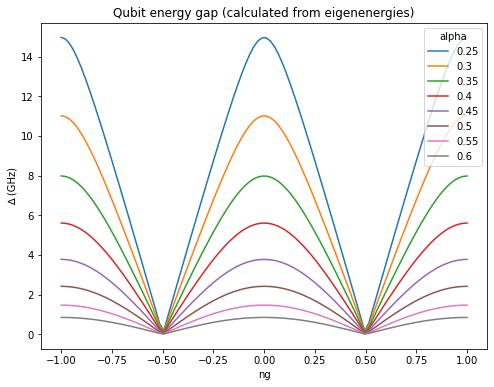

In [16]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('∆ (GHz)')

for alpha in fig_17a_results_q.keys():
    plt.plot(fig_17a_ngs_q, fig_17a_results_q[alpha], label=round(alpha,2))
plt.legend(title='alpha')
plt.show()

#### Compare to Billangeon

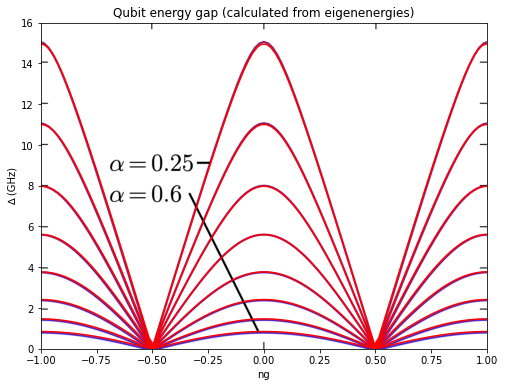

In [45]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('∆ (GHz)')

img = plt.imread("images/fig_17a.png")
for alpha in fig_17a_results_q.keys():
    plt.plot(fig_17a_ngs_q, fig_17a_results_q[alpha], 'r')
plt.ylim([0,16])

ext = [-1, 1, 0.00, 16]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

#### Fig 17b

In [54]:
fig_17b_ngs_p = np.linspace(-1, 1, 200)
Ccs = np.linspace(0, 10e-15, 12)

system = SparseSystem(ncut=5, alpha=0.4)

fig_17b_results_p = {}

for Cc in Ccs:
    fig_17b_results_q[Cc] = []
    system.Cc = Cc
    for ng in tqdm(fig_17b_ngs_q):

        system.ng = ng

        evals, evecs = system.diagonalise_q(update=True)
        evals = np.real(evals) * 1e-9 / h

        delta = evals[1] - evals[0]

        fig_17b_results_q[Cc].append(delta)

100%|█████████████████████████████████████████| 200/200 [00:20<00:00,  9.55it/s]


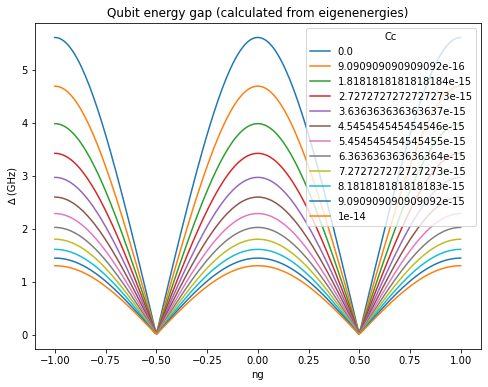

In [55]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('∆ (GHz)')

for Cc in fig_17b_results_q.keys():
    plt.plot(fig_17b_ngs_q, fig_17b_results_q[Cc], label=Cc)
plt.legend(title='Cc')
plt.show()

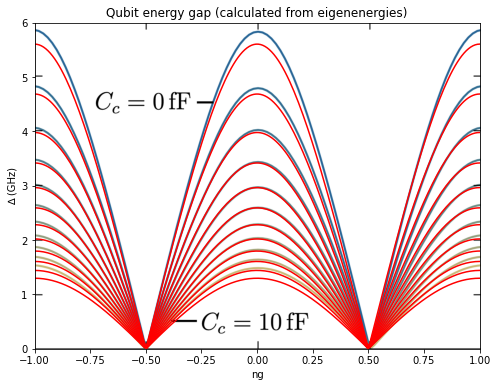

In [56]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('∆ (GHz)')

img = plt.imread("images/fig_17b.png")
for Cc in fig_17b_results_q.keys():
    plt.plot(fig_17b_ngs_q, fig_17b_results_q[Cc], 'r')

ext = [-1, 1, 0.00, 6]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

#### Fig 17c

In [64]:
fig_17c_ngs_p = np.linspace(-1, 1, 100)
fig_17c_Ccs_p = np.linspace(1e-15, 8e-15, 5)

system = SparseSystem(ncut=5, alpha=0.4)

fig_17c_results_p = {}
fig_17c_g_perp_results = {}

for Cc in fig_17c_Ccs_q:
    fig_17c_results_q[Cc] = []
    fig_17c_g_perp_results[Cc] = []
    system.Cc = Cc
    for ng in tqdm(fig_17c_ngs_q):
        system.ng = ng

        system.init_probe_states(update=True)
        
        H_q_coupling = system.get_H_q_coupling()

        g_parr = np.abs(system.hc(system.qubit_p) @ H_q_coupling @ system.qubit_m) # Try taking modulus squared without coefficient
        g_perp = np.abs(system.hc(system.qubit_1) @ H_q_coupling @ system.qubit_0)
        
        g_parr = g_parr * 1e-6 / h
        g_perp = g_perp * 1e-6 / h

        fig_17c_results_q[Cc].append(g_parr)
        fig_17c_g_perp_results[Cc].append(g_perp)

100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.89it/s]


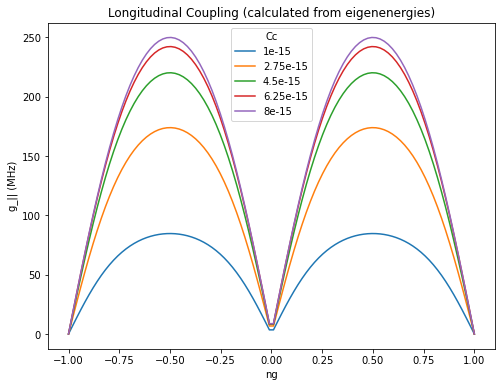

In [65]:
plt.figure(figsize=(8,6))
plt.title('Longitudinal Coupling (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('g_|| (MHz)')

for Cc in fig_17c_results_q.keys():
    plt.plot(fig_17c_ngs_q, fig_17c_results_q[Cc], label=Cc)
plt.legend(title='Cc')
plt.show()

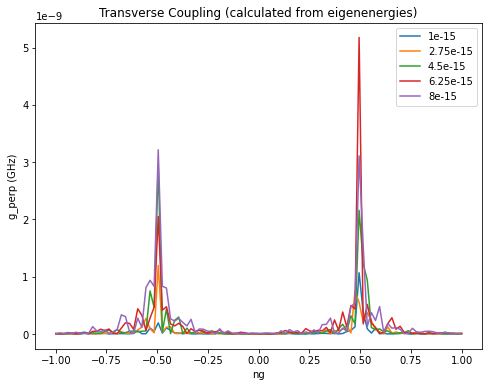

In [61]:
plt.figure(figsize=(8,6))
plt.title('Transverse Coupling (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('g_perp (GHz)')

for Cc in fig_17c_g_perp_results.keys():
    plt.plot(fig_17c_ngs, fig_17c_g_perp_results[Cc], label=Cc)
plt.legend()
plt.show()

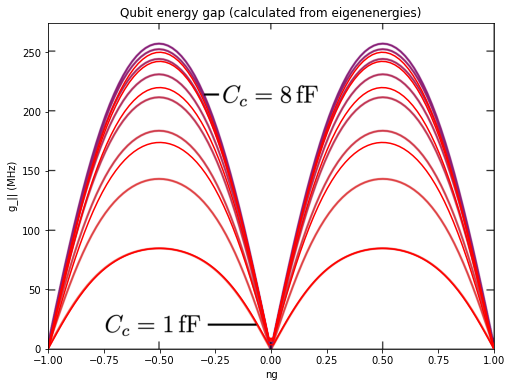

In [126]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('g_|| (MHz)')

img = plt.imread("images/fig_17c.png")
for alpha in fig_17c_results_q.keys():
    plt.plot(fig_17c_ngs_q, fig_17c_results_q[alpha], 'r')
plt.ylim([0,275])

ext = [-1, 1, 0.00, 275]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

#### Fig 17d

In [18]:
fig_17d_Ccs_p = np.linspace(0, 10e-15, 200)

system = SparseSystem(ncut=6, ng=0.25)

fig_17d_results_p = []

for Cc in tqdm(fig_17d_Ccs_q):
    system.Cc = Cc

    system.init_probe_states(update=True)
    H_q_coupling = system.get_H_q_coupling()

    g_parr = np.abs(system.hc(system.qubit_p) @ H_q_coupling @ system.qubit_m)
    g_parr = g_parr * 1e-6 / h

    fig_17d_results_q.append(g_parr)

  0%|                                                   | 0/200 [00:00<?, ?it/s]


AttributeError: 'SparseSystem' object has no attribute 'alpha'

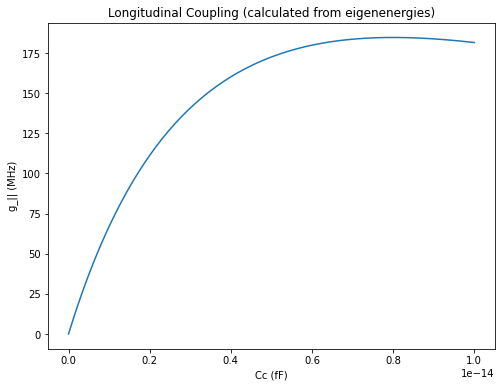

In [74]:
plt.figure(figsize=(8,6))
plt.title('Longitudinal Coupling (calculated from eigenenergies)')
plt.xlabel('Cc (fF)')
plt.ylabel('g_|| (MHz)')

plt.plot(fig_17d_Ccs_q, fig_17d_results_q)
plt.show()

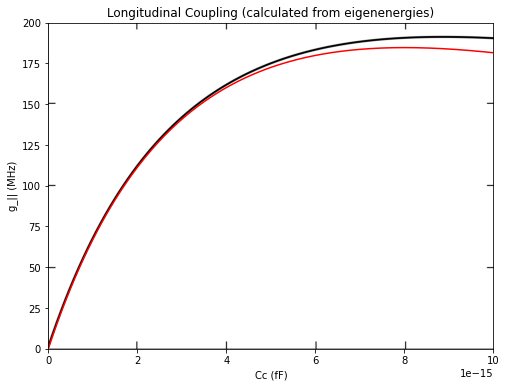

In [128]:
plt.figure(figsize=(8,6))
plt.title('Longitudinal Coupling (calculated from eigenenergies)')
plt.xlabel('Cc (fF)')
plt.ylabel('g_|| (MHz)')

img = plt.imread("images/fig_17d.png")
plt.plot(fig_17d_Ccs_q, fig_17d_results_q, 'r')
plt.ylim([0,200])

ext = [0, 1e-14, 0.00, 200]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

# Determine Approximate Hamiltonian Parameters

We assume that the Hamiltonian can be approximated by

\begin{equation}
    H = \omega_r' a^\dagger a + \frac{\Delta}{2} \sigma_z + i g_{\parallel} \sigma_z \left( a^\dagger - a \right) + g_{\perp} \sigma_x \left( a^\dagger + a \right)
\end{equation}

which when writing the two subspaces explicitly is written as

\begin{equation}
    H = \omega_r' \mathbb{1} \otimes a^\dagger a + \frac{\Delta}{2} \sigma_z \otimes \mathbb{1} + i g_{\parallel} \sigma_z \otimes \left( a^\dagger - a \right) + g_{\perp} \sigma_x \otimes \left( a^\dagger + a \right)
\end{equation}

To find the parameters I previously took the following overlaps:

\begin{equation}
    \langle 0 | \langle 0 | H | 0 \rangle | 0 \rangle = \frac{\Delta}{2}
\end{equation}

\begin{equation}
    \langle 0 | \langle 1 | H | 0 \rangle | 1 \rangle = \omega_r' + \frac{\Delta}{2}
\end{equation}

\begin{equation}
    \langle + | \langle 1 | H | - \rangle | 0 \rangle = i g_{\parallel}
\end{equation}

\begin{equation}
    \langle 1 | \langle 1 | H | 0 \rangle | 0 \rangle = g_{\perp}
\end{equation}

where we use the notation $| \text{Qubit} \rangle | \text{Cavity} \rangle$

This did not yield the expected results for $ \Delta $ (but did yield correct* results for $\omega$ and the couplings), instead for $\Delta$ taking:

\begin{equation}
    \langle 1 | \langle 0 | H | 1 \rangle | 0 \rangle - \langle 0 | \langle 0 | H | 0 \rangle | 0 \rangle = \frac{\Delta}{2}
\end{equation}

has yielded the Qubit + Resontar graphs of fig17(a,b)

*correct up to a factor of ~1.8x

### Evaluate parameters

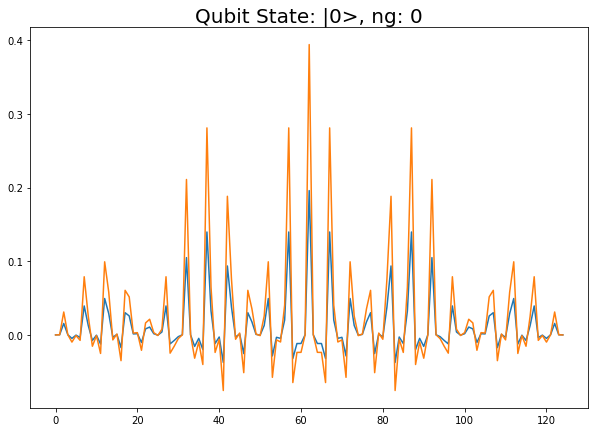

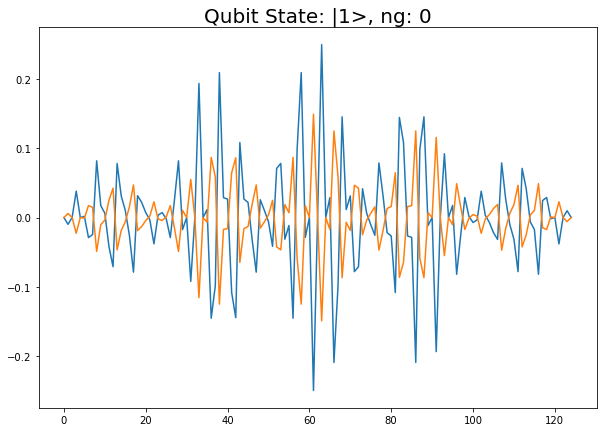

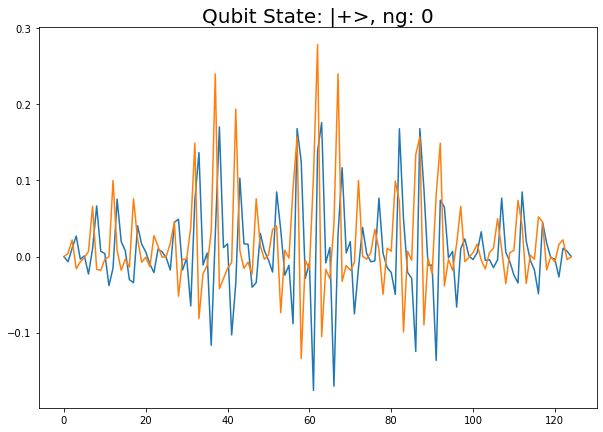

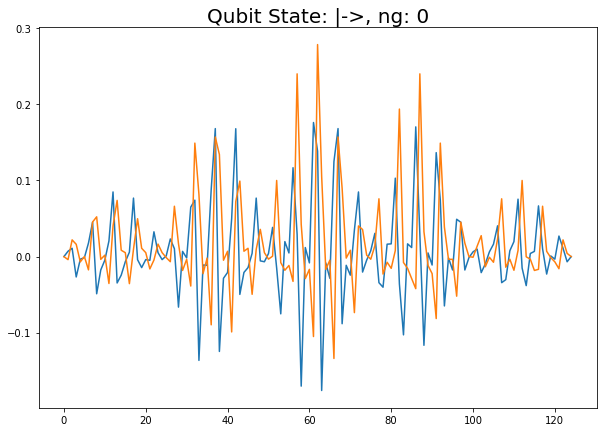

In [130]:
system = SparseSystem(ncut=2, mcut=2, ng=0)
H_p = system._plot_qubit_states()

In [128]:
system = SparseSystem(ncut=5, ng=0.5)

g_parr = system.calc_g_parr()
print(f"g parallel: {g_parr}")

g_perp = system.calc_g_perp()
print(f"g perpendicular: {g_perp}")

delta = system.calc_delta()
print(f"delta: {delta}")

omega = system.calc_omega()
print(f"omega: {omega}")

g parallel: (2.1500677626953903e-25+1.0401168610243717e-32j)
g perpendicular: (1.0401168516301018e-32+5.356955960202363e-31j)
delta: (1.793476923257936e-22-5.877471754111438e-38j)
omega: (3.2972967748424806e-24+1.7632415262334313e-38j)


### Expected $\omega_r'$

Here we compute the expected resonant frequency of the resonator using the equation

\begin{equation}
    \omega_r' = \hbar / \sqrt{L_r C_r'}
\end{equation}

where $C_r'$ is the renormalised resonator capacitance, as defined in eq A16.

In [98]:
omega_exp = system.calc_bil_omega()
print(f"omega exp: {omega_exp}")

omega exp: 3.2970672320050607e-24


## Calculating Coupling with Eq A15 

In Billangeon et al they express the coupling parameters as:

\begin{equation}
    g_\perp = \langle 1 | \sqrt{\frac{\hbar}{2 Z_r'}} \left[ \alpha (1 + \alpha) \frac{C_c}{C_0^2} (\hat{q}_1 + \hat{q}_2) + (1 + \alpha)^2 \frac{C_c}{C_0^2} \hat{q}_I \right] | 0 \rangle
\end{equation}

\begin{equation}
    g_\parallel = \langle + | \sqrt{\frac{\hbar}{2 Z_r'}} \left[ \alpha (1 + \alpha) \frac{C_c}{C_0^2} (\hat{q}_1 + \hat{q}_2) + (1 + \alpha)^2 \frac{C_c}{C_0^2} \hat{q}_I \right] | - \rangle
\end{equation}

In [99]:
g_parr_bil, g_perp_bil = system.calc_bil_coupling()

print(f"g parallel: {g_parr_bil}")
print(f"g perpendicular: {g_perp_bil}")

g parallel: (1.1810388816452003e-25+2.663801349086326e-34j)
g perpendicular: (4.5649992006947017e-32-2.6638011204353913e-34j)


## Figure 17a

In [84]:
system = SparseSystem(ncut=6, Cc=0)
fig17a_ngs_pt = np.linspace(-1, 1, 100)
alphas = np.linspace(0.25, 0.6, 8)
fig17a_data_pt = {}

for alpha in alphas:
    system.alpha = alpha
    fig17a_data_pt[alpha] = []
    for ng in tqdm(fig17a_ngs_pt):
        system.ng = ng

        # Full Hamiltonina Approach
        delta = system.calc_delta(update=True)
        fig17a_data_pt[alpha].append(delta)

100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.01it/s]


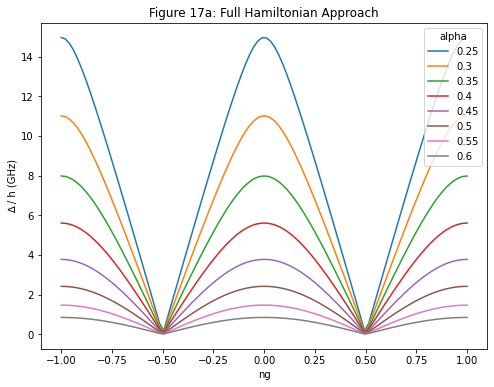

In [85]:
plt.figure(figsize=(8,6))
plt.title('Figure 17a: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('∆ / h (GHz)')
for alpha in fig17a_data_pt.keys():
    plt.plot(fig17a_ngs_pt, [np.real(delta * 1e-9) / h for delta in fig17a_data_pt[alpha]], label=round(alpha,2))
plt.legend(title='alpha')
plt.show()

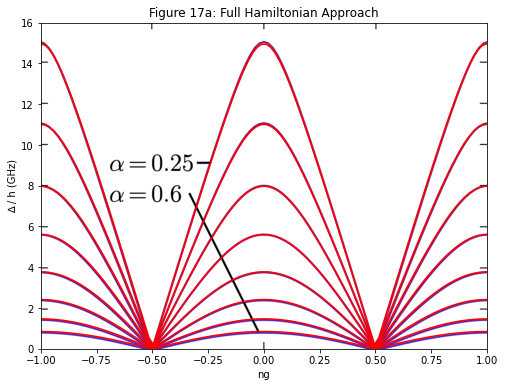

In [129]:
plt.figure(figsize=(8,6))
plt.title('Figure 17a: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('∆ / h (GHz)')

img = plt.imread("images/fig_17a.png")
for alpha in fig17a_data_pt.keys():
    plt.plot(fig17a_ngs_pt, [np.real(delta * 1e-9) / h for delta in fig17a_data_pt[alpha]], 'r')

ext = [-1, 1, 0.00, 16]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

## Figure 17b

In [95]:
system = SparseSystem(ncut=6, alpha=0.4)
fig17b_ngs_pt = np.linspace(-1, 1, 100)
Ccs = np.linspace(0, 10e-15, 12)
fig17b_data_pt = {}

for Cc in Ccs:
    system.Cc = Cc
    fig17b_data_pt[Cc] = []
    for ng in tqdm(fig17b_ngs_pt):
        system.ng = ng

        # Full Hamiltonina Approach
        delta = system.calc_delta(update=True)
        fig17b_data_pt[Cc].append(delta)

100%|█████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


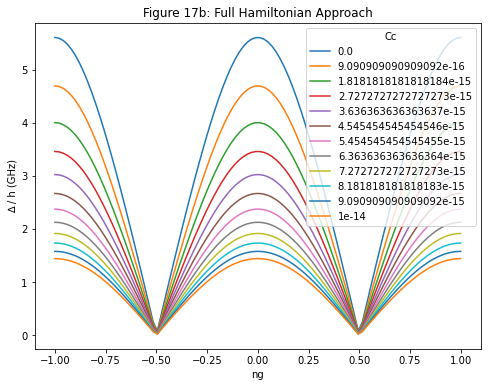

In [96]:
plt.figure(figsize=(8,6))
plt.title('Figure 17b: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('∆ / h (GHz)')
for Cc in fig17b_data_pt.keys():
    plt.plot(fig17b_ngs_pt, [np.real(delta * 1e-9) / h for delta in fig17b_data_pt[Cc]], label=Cc)
plt.legend(title='Cc')
plt.show()

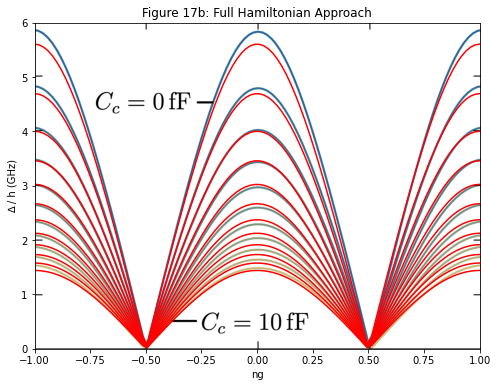

In [130]:
plt.figure(figsize=(8,6))
plt.title('Figure 17b: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('∆ / h (GHz)')

img = plt.imread("images/fig_17b.png")
for alpha in fig17b_data_pt.keys():
    plt.plot(fig17b_ngs_pt, [np.real(delta * 1e-9) / h for delta in fig17b_data_pt[alpha]], 'r')

ext = [-1, 1, 0.00, 6]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

## Figure 17c

In [26]:
system = SparseSystem(ncut=5)
fig17c_ngs_pt = np.linspace(-1, 1, 100)
fig_17c_Ccs_pt = np.linspace(1e-15, 8e-15, 2)
fig17c_data_pt = {}

for Cc in fig_17c_Ccs_pt:
    system.Cc = Cc
    fig17c_data_pt[Cc] = []
    for ng in tqdm(fig17c_ngs_pt):
        system.ng = ng

        # Full Hamiltonina Approach
        g_parr = system.calc_g_parr(update=True)
        fig17c_data_pt[Cc].append(g_parr)

100%|█████████████████████████████████████████| 100/100 [00:37<00:00,  2.68it/s]


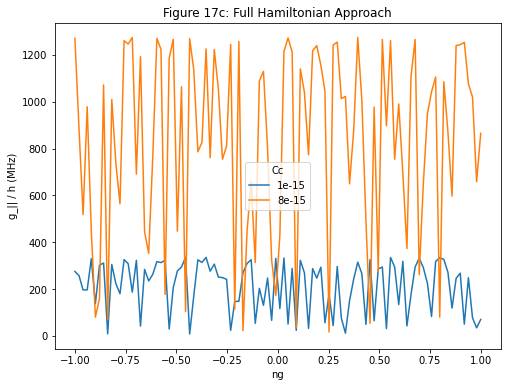

In [27]:
plt.figure(figsize=(8,6))
plt.title('Figure 17c: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('g_|| / h (MHz)')
for Cc in fig17c_data_pt.keys():
    plt.plot(fig17c_ngs_pt, [np.abs(g_parr * 1e-6) / h for g_parr in fig17c_data_pt[Cc]], label=Cc)
plt.legend(title='Cc')
plt.show()

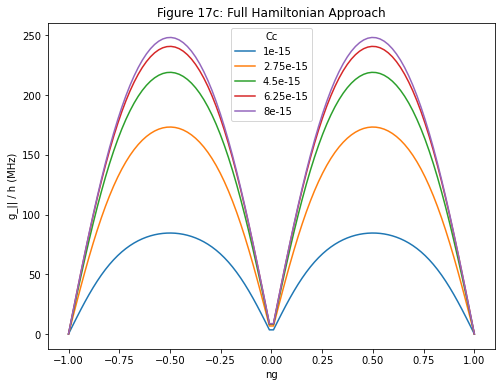

In [107]:
plt.figure(figsize=(8,6))
plt.title('Figure 17c: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('g_|| / h (MHz)')
for Cc in fig17c_data_pt.keys():
    plt.plot(fig17c_ngs_pt, [np.abs(g_parr * 1e-6) / h for g_parr in fig17c_data_pt[Cc]], label=Cc)
plt.legend(title='Cc')
plt.show()

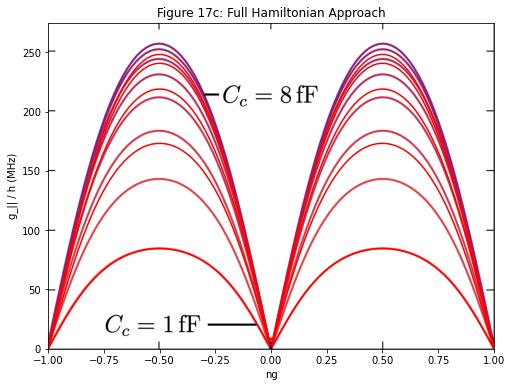

In [131]:
plt.figure(figsize=(8,6))
plt.title('Figure 17c: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('g_|| / h (MHz)')

img = plt.imread("images/fig_17c.png")
for Cc in fig17c_data_pt.keys():
    plt.plot(fig17c_ngs_pt, [np.abs(delta * 1e-6) / h for delta in fig17c_data_pt[Cc]], 'r')
plt.ylim([0,275])

ext = [-1, 1, 0.00, 275]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

## Varying Cc (Figure 17d)

In [23]:
system = SparseSystem(ncut=6)

fig_17d_Ccs_pt = np.linspace(0, 10e-15, 20)
fig17d_data_pt = {}
fig17d_data_pt['FH'] = []
fig17d_data_pt['Bil'] = []

for Cc in tqdm(fig_17d_Ccs_pt):
    system.Cc = Cc
    
    # Full Hamiltonina Approach
    g_parr = system.calc_g_parr(update=True)
    fig17d_data_pt['FH'].append(g_parr)

    # Billangeon Eq A15 Approach
    # g_parr_bil, g_perp_bil = system.calc_bil_coupling(update=True)
    # fig17d_data_pt['Bil'].append(g_parr_bil)

100%|███████████████████████████████████████████| 20/20 [00:12<00:00,  1.54it/s]


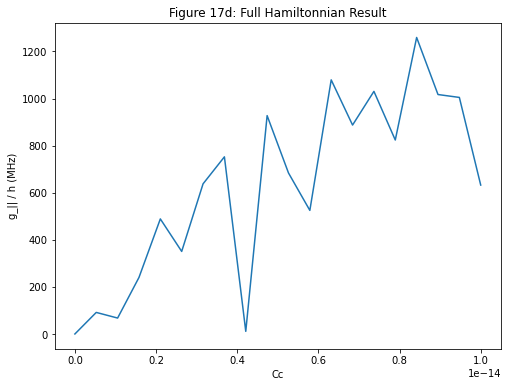

In [25]:
plt.figure(figsize=(8,6))

# ax1 = f.add_subplot(121)
plt.title('Figure 17d: Full Hamiltonnian Result')
plt.xlabel('Cc')
plt.ylabel('g_|| / h (MHz)')
plt.plot(fig_17d_Ccs_pt, [np.abs(g_parr * 1e-6) / h for g_parr in fig17d_data_pt['FH']])

# ax2 = f.add_subplot(122)
# ax2.title.set_text('Eq A15 coupling result')
# ax2.set_xlabel('Cc')
# ax2.set_ylabel('g_|| / h (MHz)')
# ax2.plot(fig_17d_Ccs_pt, [np.abs(g_parr_bil * 1e-6) / h for g_parr_bil in fig17d_data_pt['Bil']])
plt.show()

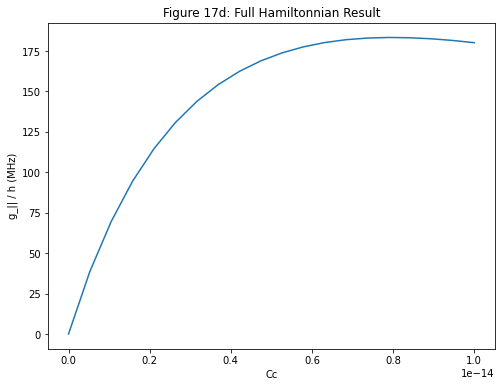

In [132]:
plt.figure(figsize=(8,6))

# ax1 = f.add_subplot(121)
plt.title('Figure 17d: Full Hamiltonnian Result')
plt.xlabel('Cc')
plt.ylabel('g_|| / h (MHz)')
plt.plot(fig_17d_Ccs_pt, [np.abs(g_parr * 1e-6) / h for g_parr in fig17d_data_pt['FH']])

# ax2 = f.add_subplot(122)
# ax2.title.set_text('Eq A15 coupling result')
# ax2.set_xlabel('Cc')
# ax2.set_ylabel('g_|| / h (MHz)')
# ax2.plot(fig_17d_Ccs_pt, [np.abs(g_parr_bil * 1e-6) / h for g_parr_bil in fig17d_data_pt['Bil']])
plt.show()

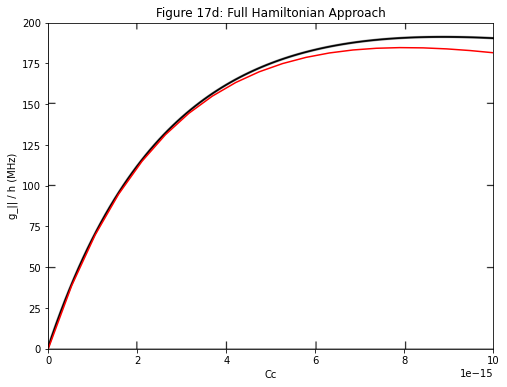

In [133]:
plt.figure(figsize=(8,6))
plt.title('Figure 17d: Full Hamiltonian Approach')
plt.xlabel('Cc')
plt.ylabel('g_|| / h (MHz)')

img = plt.imread("images/fig_17d.png")
plt.plot(fig_17d_Ccs_pt, [np.abs(g_parr * 1e-6) / h for g_parr in fig17d_data_pt['Bil']], 'r')
plt.ylim([0, 200])
    
ext = [0, 1e-14, 0.00, 200]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()